### We are aiming to get answers for these questions from given dataset
#### Questionnaire

1. What percentage of customers have fully paid their Loan Amount?
2. Comment about the correlation between Loan Amount and Installment features.
3. The majority of people have home ownership as _______.
4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)
2. Name the top 2 afforded job titles.
6. Thinking from a bank's perspective, which metric should our primary focus be on..
   1. ROC AUC
   2. Precision
   3. Recall
   4. F1 Score
7. How does the gap in precision and recall affect the bank?
8. Which were the features that heavily affected the outcome?
9. Will the results be affected by geographical location? (Yes/No)

#### Problem statement 
Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('loantap.txt')
df.sample(8)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
138069,22000.0,36 months,10.15,711.43,B,B2,Materials & Distribution Associate,10+ years,RENT,67500.0,...,19.0,0.0,3940.0,11.2,23.0,w,INDIVIDUAL,0.0,0.0,86985 Peterson Centers Suite 055\r\nFarrellbur...
166089,17000.0,36 months,8.39,535.79,B,B1,AVP-Development,6 years,MORTGAGE,115000.0,...,8.0,0.0,5451.0,47.8,31.0,w,INDIVIDUAL,3.0,0.0,"0931 Tonya Ridge\r\nJenniferport, MO 48052"
336317,20000.0,36 months,12.49,668.98,B,B5,Driver,4 years,OWN,90000.0,...,12.0,0.0,21484.0,81.1,27.0,f,INDIVIDUAL,0.0,0.0,"6749 Evans Field Suite 046\r\nWest Daniel, FL ..."
51165,8000.0,36 months,9.67,256.90,B,B1,Vehicle Maintenance Manager,10+ years,MORTGAGE,100000.0,...,13.0,0.0,15854.0,48.3,45.0,f,INDIVIDUAL,7.0,0.0,"1265 Kara Mills\r\nLiufurt, OH 22690"
390158,28000.0,36 months,10.99,916.56,B,B3,Vice President,2 years,OWN,200000.0,...,16.0,0.0,109377.0,39.3,31.0,f,INDIVIDUAL,3.0,0.0,"9664 Michael Center Apt. 507\r\nLake Melissa, ..."
81197,6000.0,36 months,9.67,192.68,B,B1,Service Technician,6 years,MORTGAGE,78000.0,...,7.0,0.0,9538.0,85.9,18.0,w,INDIVIDUAL,3.0,0.0,USNS Foster\r\nFPO AP 48052
374299,10000.0,36 months,16.99,356.48,D,D3,NaN,NaN,MORTGAGE,68858.0,...,15.0,0.0,51083.0,94.8,20.0,w,INDIVIDUAL,1.0,0.0,94144 Samantha Manors Apt. 678\r\nEast Christo...
1260,30225.0,60 months,24.50,878.31,F,F3,Registered Nurse,10+ years,RENT,68000.0,...,9.0,0.0,12514.0,61.0,35.0,w,INDIVIDUAL,1.0,0.0,"PSC 6809, Box 5916\r\nAPO AP 70466"


### Column details
1. loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
2. term : The number of payments on the loan. Values are in months and can be either 36 or 60.
3. int_rate : Interest Rate on the loan
4. installment : The monthly payment owed by the borrower if the loan originates.
5. grade : LoanTap assigned loan grade
6. sub_grade : LoanTap assigned loan subgrade
7. emp_title :The job title supplied by the Borrower when applying for the loan.*
8. emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
9. home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report.
10. annual_inc : The self-reported annual income provided by the borrower during registration.
11. verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified
12. issue_d : The month which the loan was funded
13. loan_status : Current status of the loan - Target Variable
14. purpose : A category provided by the borrower for the loan request.
15. title : The loan title provided by the borrower
16. dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
17. earliest_cr_line :The month the borrower's earliest reported credit line was opened
18. open_acc : The number of open credit lines in the borrower's credit file.
19. pub_rec : Number of derogatory public records
20. revol_bal : Total credit revolving balance
21. revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
22. total_acc : The total number of credit lines currently in the borrower's credit file
23. initial_list_status : The initial listing status of the loan. Possible values are – W, F
24. application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
25. mort_acc : Number of mortgage accounts.
26. pub_rec_bankruptcies : Number of public record bankruptcies
27. Address: Address of the individual

In [4]:
df.shape

(396030, 27)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [6]:
100*df.isnull().sum()/len(df)

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

#### Insight 
Following columns has missing values 
1. emp_title has 5.78% missing values 
2. emp_length has 4.62% missing values 
3. title has 0.44% missing values 
4. revol_until has 0.06% missing values 
5. mort_acc has 9.54% missing values 
6. pub_rec_bankruptcies has 0.13% missing values 

#### Action
Since ML algorithm do not work on columns which has missing values so we need to impute these missing values 

In [7]:
df['emp_title'] = df['emp_title'].fillna('Other')

In [8]:
df[df['emp_length'].isnull()]['annual_inc'].mean()

49514.22070597223

In [9]:
emp_length_sum_income = df.groupby('emp_length')['annual_inc'].mean()

# Sort the results by the sum of annual income in ascending order
sorted_emp_length_sum_income = emp_length_sum_income.sort_values()
sorted_emp_length_sum_income

emp_length
< 1 year     69194.399887
1 year       69700.714303
2 years      71768.216806
4 years      72788.310415
3 years      72862.784181
5 years      73185.418388
6 years      73610.048841
7 years      74013.635764
8 years      75466.537177
9 years      75514.539483
10+ years    81262.885450
Name: annual_inc, dtype: float64

In [10]:
df['emp_length'] = df['emp_length'].fillna('< 1 year')

In [11]:
emp_length_sum_income = df.groupby('emp_length')['annual_inc'].mean()

# Sort the results by the sum of annual income in ascending order
sorted_emp_length_sum_income = emp_length_sum_income.sort_values()
sorted_emp_length_sum_income

emp_length
< 1 year     61994.804493
1 year       69700.714303
2 years      71768.216806
4 years      72788.310415
3 years      72862.784181
5 years      73185.418388
6 years      73610.048841
7 years      74013.635764
8 years      75466.537177
9 years      75514.539483
10+ years    81262.885450
Name: annual_inc, dtype: float64

In [12]:
df['title'] = df['title'].fillna(df['title'].mode()[0])

In [13]:
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

In [14]:
df['mort_acc'] = df['mort_acc'].fillna(df['mort_acc'].mode()[0])

In [15]:
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(df['pub_rec_bankruptcies'].mode()[0])

In [16]:
100*df.isnull().sum()/len(df)

loan_amnt               0.0
term                    0.0
int_rate                0.0
installment             0.0
grade                   0.0
sub_grade               0.0
emp_title               0.0
emp_length              0.0
home_ownership          0.0
annual_inc              0.0
verification_status     0.0
issue_d                 0.0
loan_status             0.0
purpose                 0.0
title                   0.0
dti                     0.0
earliest_cr_line        0.0
open_acc                0.0
pub_rec                 0.0
revol_bal               0.0
revol_util              0.0
total_acc               0.0
initial_list_status     0.0
application_type        0.0
mort_acc                0.0
pub_rec_bankruptcies    0.0
address                 0.0
dtype: float64

Q1. What percentage of customers have fully paid their Loan Amount?
##### Ans1 - 80.387% people have fully paid their loan amount

In [17]:
df['loan_status'].value_counts()*100/len(df)

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64

Q2. Comment about the correlation between Loan Amount and Installment features 
#### Ans2 - These two features are stringly positivlyy related to eachother and can be seen through scatter plot as well as correlation matrix

In [18]:
df[['loan_amnt', 'installment']].corr()

,loan_amnt,installment
loan_amnt,1.000000,0.953929
installment,0.953929,1.000000


<AxesSubplot:xlabel='loan_amnt', ylabel='installment'>

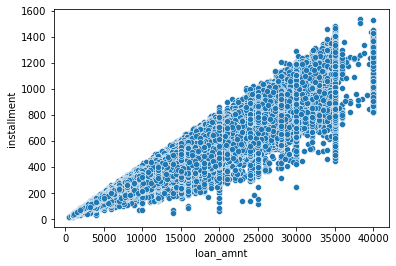

In [19]:
sns.scatterplot(df['loan_amnt'], df['installment'])

Q3. The majority of people have home ownership as ?
#### Ans3 - 50.1% people has Home Ownership as Mortgage in our dataset

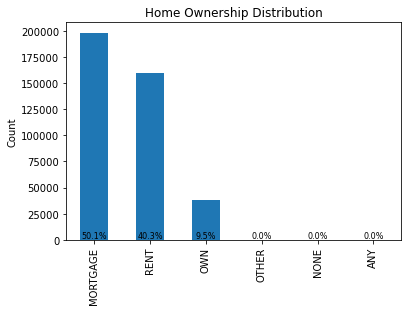

In [20]:
value_counts = df['home_ownership'].value_counts()

# Calculate the percentage values
percentage_values = (value_counts / len(df)) * 100

# Create a bar plot
ax = value_counts.plot(kind='bar')
ax.set_ylabel('Count')
ax.set_title('Home Ownership Distribution')

# Display the data labels (percentages) on the bars
for index, value in enumerate(percentage_values):
    ax.text(index, value, f'{value:.1f}%', ha='center', va='bottom', fontsize=8)

# Display the plot
plt.show()

Q4. Are people with grades ‘A’ are more likely to fully pay their loan ?
#### Ans4 - yes people with grade 'A' are more likly to pay their loan fully

In [21]:
pd.crosstab(df['grade'],df['loan_status'], normalize = 'index')

loan_status,Charged Off,Fully Paid
grade,,
A,0.062879,0.937121
B,0.125730,0.874270
C,0.211809,0.788191
D,0.288678,0.711322
E,0.373634,0.626366
F,0.427880,0.572120
G,0.478389,0.521611


Q5. Name the top 2 afforded job titles 
#### Ans5 - Teacher and Manager

In [22]:
df['emp_title'].value_counts()

Other                      22928
Teacher                     4389
Manager                     4250
Registered Nurse            1856
RN                          1846
                           ...  
Postman                        1
McCarthy & Holthus, LLC        1
jp flooring                    1
Histology Technologist         1
Gracon Services, Inc           1
Name: emp_title, Length: 173105, dtype: int64

### Extracting numerical information from object type columns like terms and emp_length

In [23]:
df['term'] = df['term'].str.split().str[0].astype('int32')

In [24]:
def fun(x):
    if x == '10+ years':
        return 10
    elif x == '< 1 year':
        return 0.5
    else:
        return int(x.split()[0])

df['emp_length'] = df['emp_length'].apply(fun)

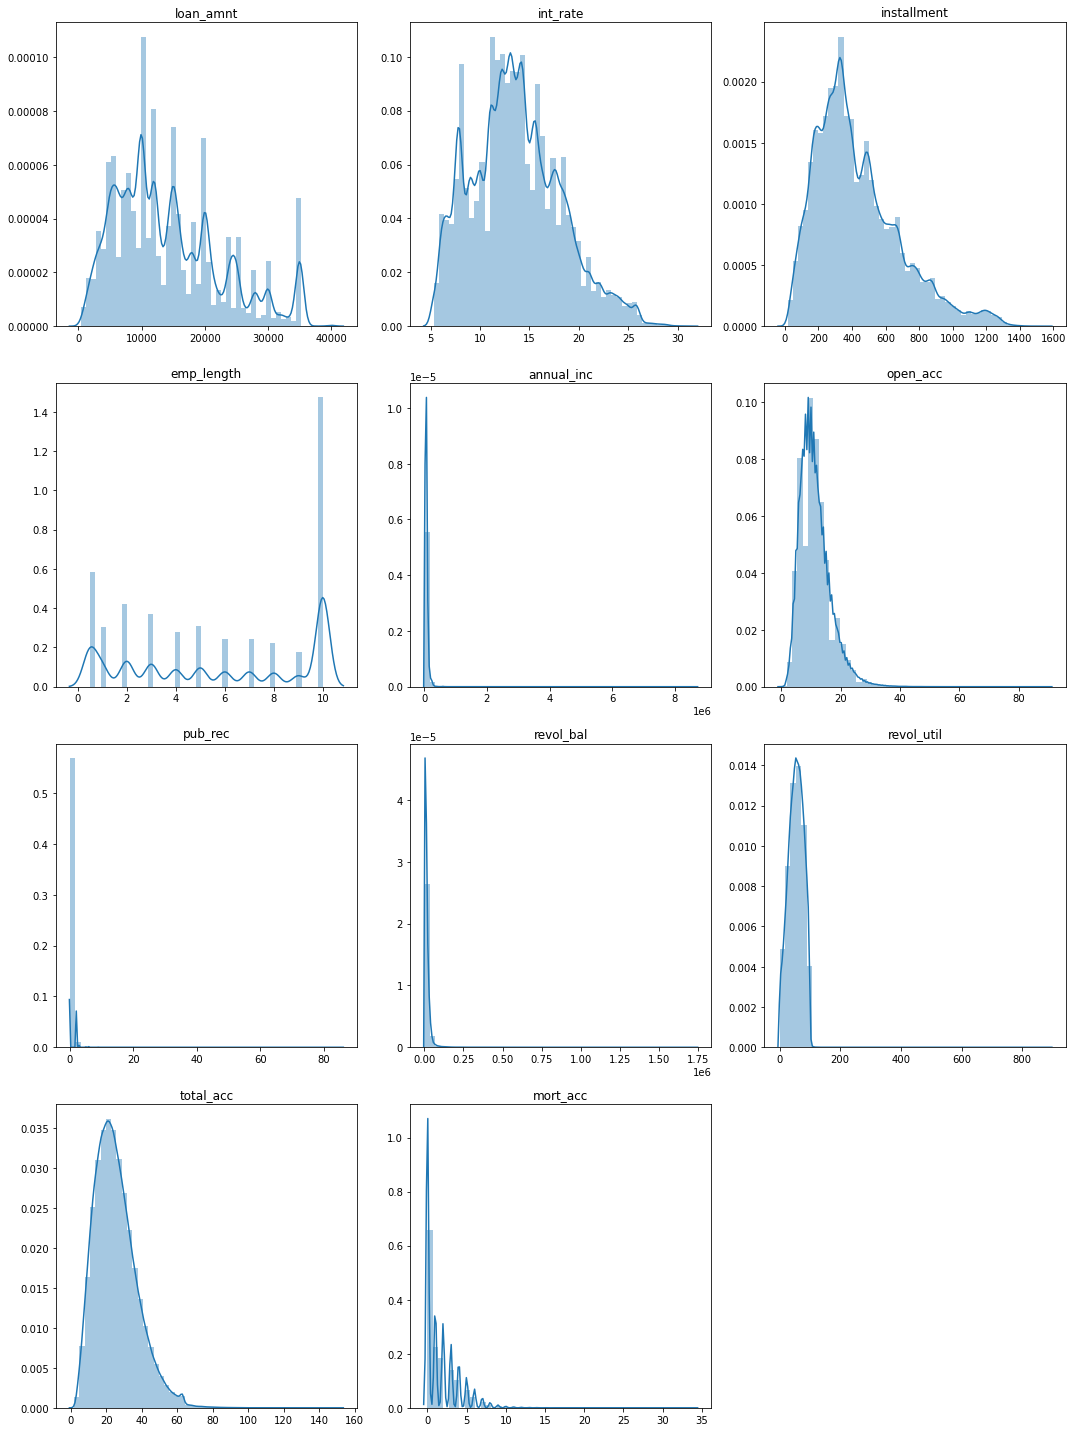

In [25]:
col = ['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc']

# Calculate the number of rows and columns for the grid layout
num_cols = 3
num_rows = (len(col) + num_cols - 1) // num_cols

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.subplots_adjust(hspace=0.5)

# Loop through columns and create distribution plots
for idx, column_name in enumerate(col):
    row = idx // num_cols
    col_idx = idx % num_cols
    sns.distplot(df[column_name], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(column_name)
    axes[row, col_idx].set_xlabel('')  # Remove x-label for better readability
    axes[row, col_idx].set_ylabel('')  # Remove y-label for better readability

# Hide any empty subplots if the number of plots is not a perfect multiple of num_cols
for idx in range(len(col), num_rows * num_cols):
    row = idx // num_cols
    col_idx = idx % num_cols
    fig.delaxes(axes[row, col_idx])

plt.tight_layout()
plt.show()

#### Insights 
1. mort_acc, total_acc, revol_bal, pub_rec, revol_util, annual_inc these columns are left skewed

#### Action
need to apply log transformations in order to normalise them 

### Univariate and Bivariate analysis of Categorical columns 

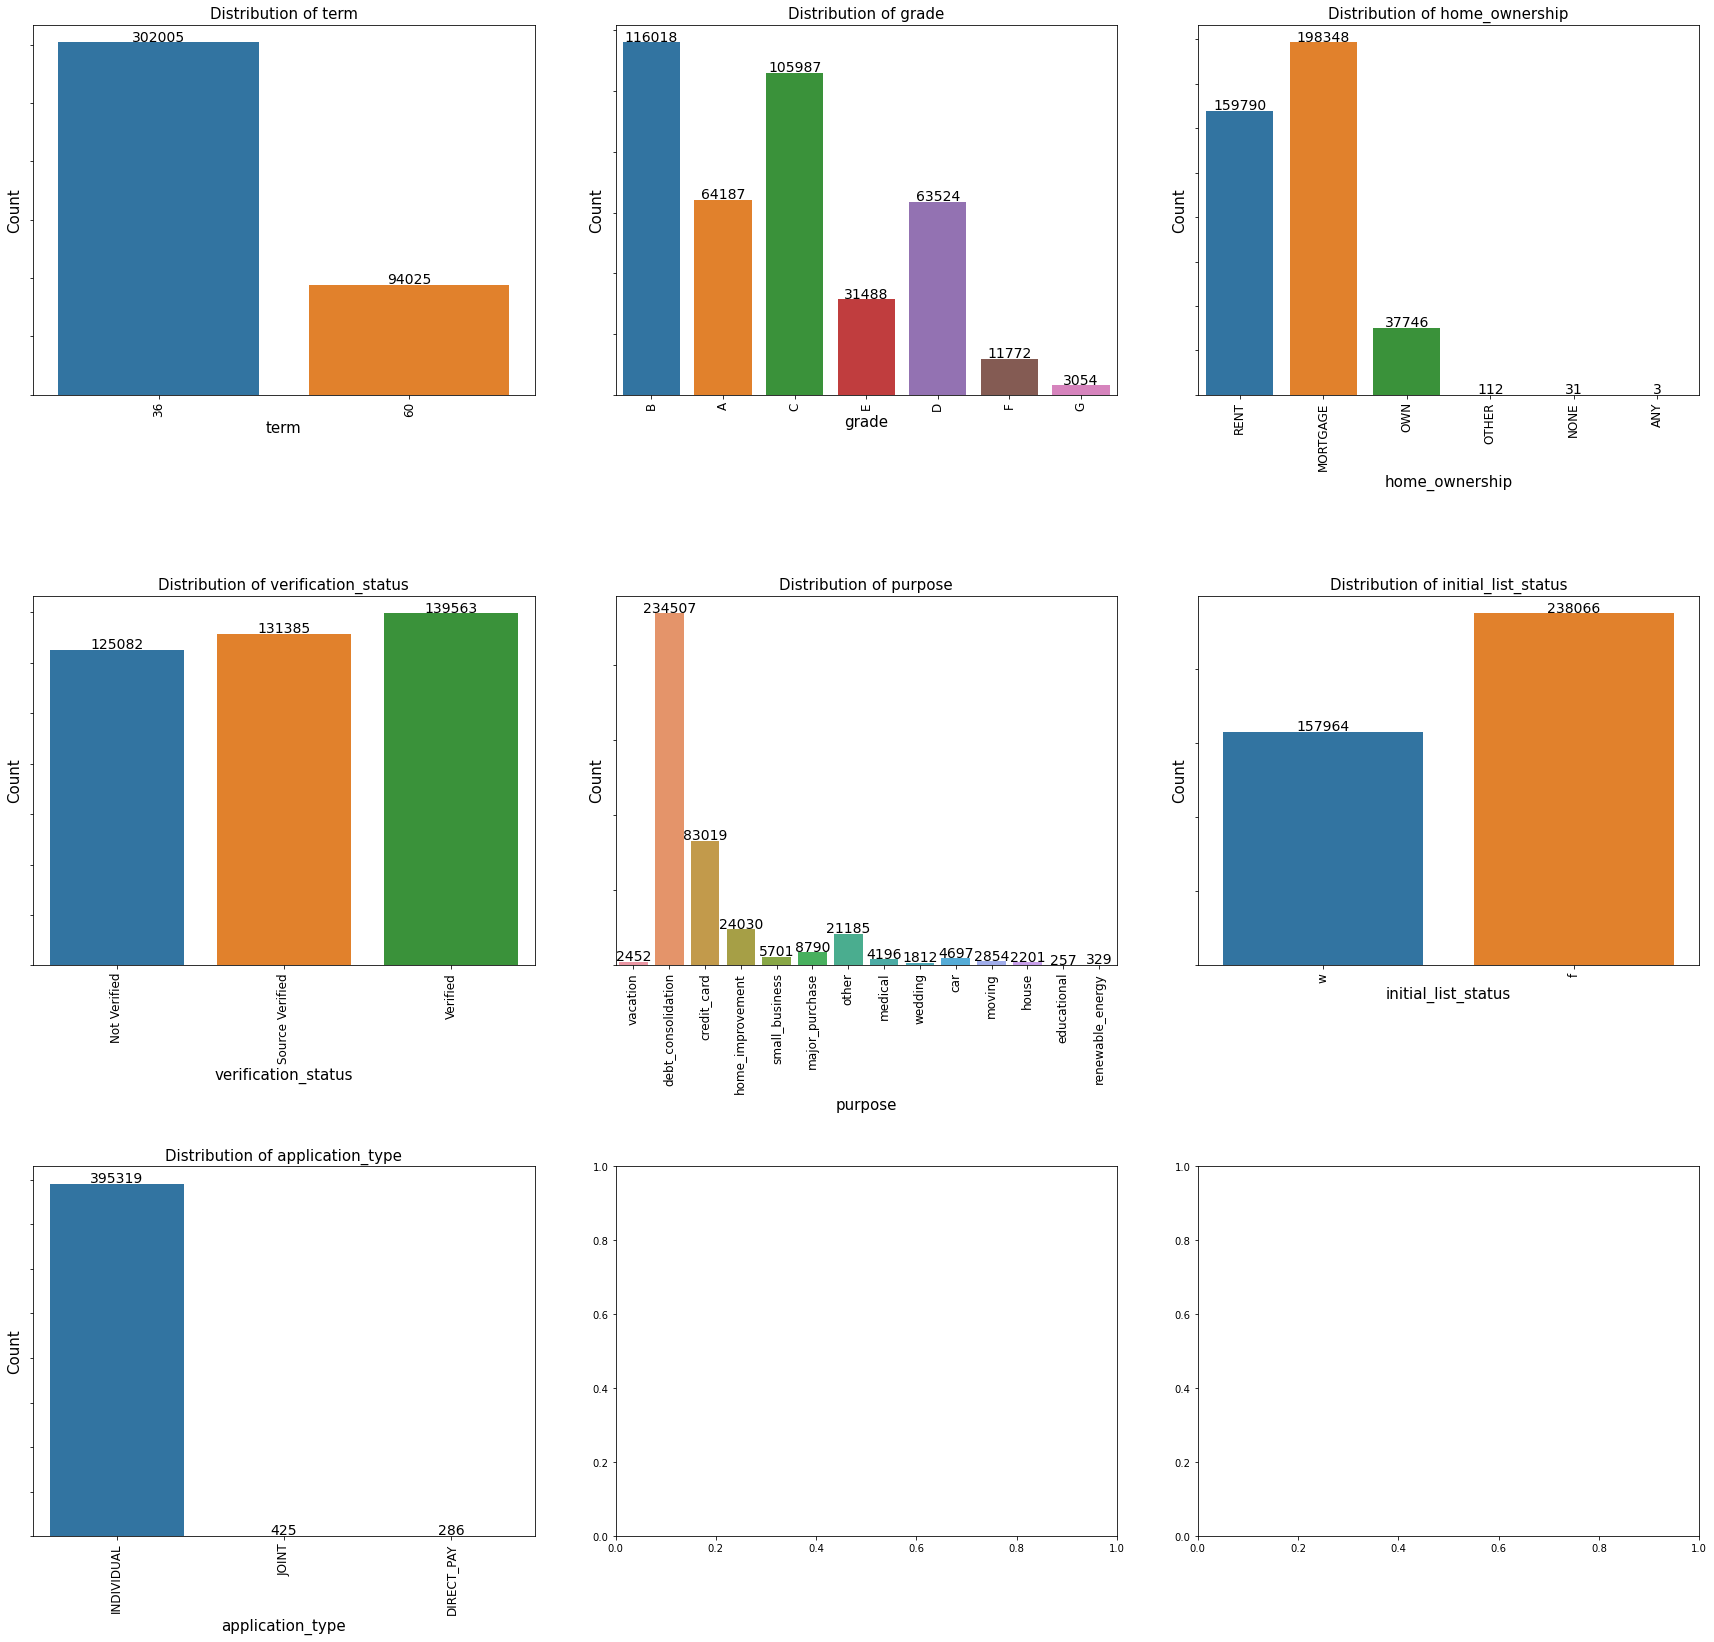

In [26]:
columns_to_plot = ['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']

# Calculate the number of rows and columns for the grid layout
num_cols = 3
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 8 * num_rows))
fig.subplots_adjust(hspace=0.5)

# Loop through columns and create distribution plots
for i, column in enumerate(columns_to_plot):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    sns.countplot(data=df, x=column, ax=ax)
    ax.set_title(f'Distribution of {column}', fontsize=15)
    ax.set_xlabel(column, fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    
    # Rotate x-axis tick labels vertically
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)  # Adjust font size here
    
    # Manually place count labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=14, color='black', xytext=(0, 5),
                    textcoords='offset points')

    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)  # Adjust font size here

plt.tight_layout(pad=5.0)
plt.show()

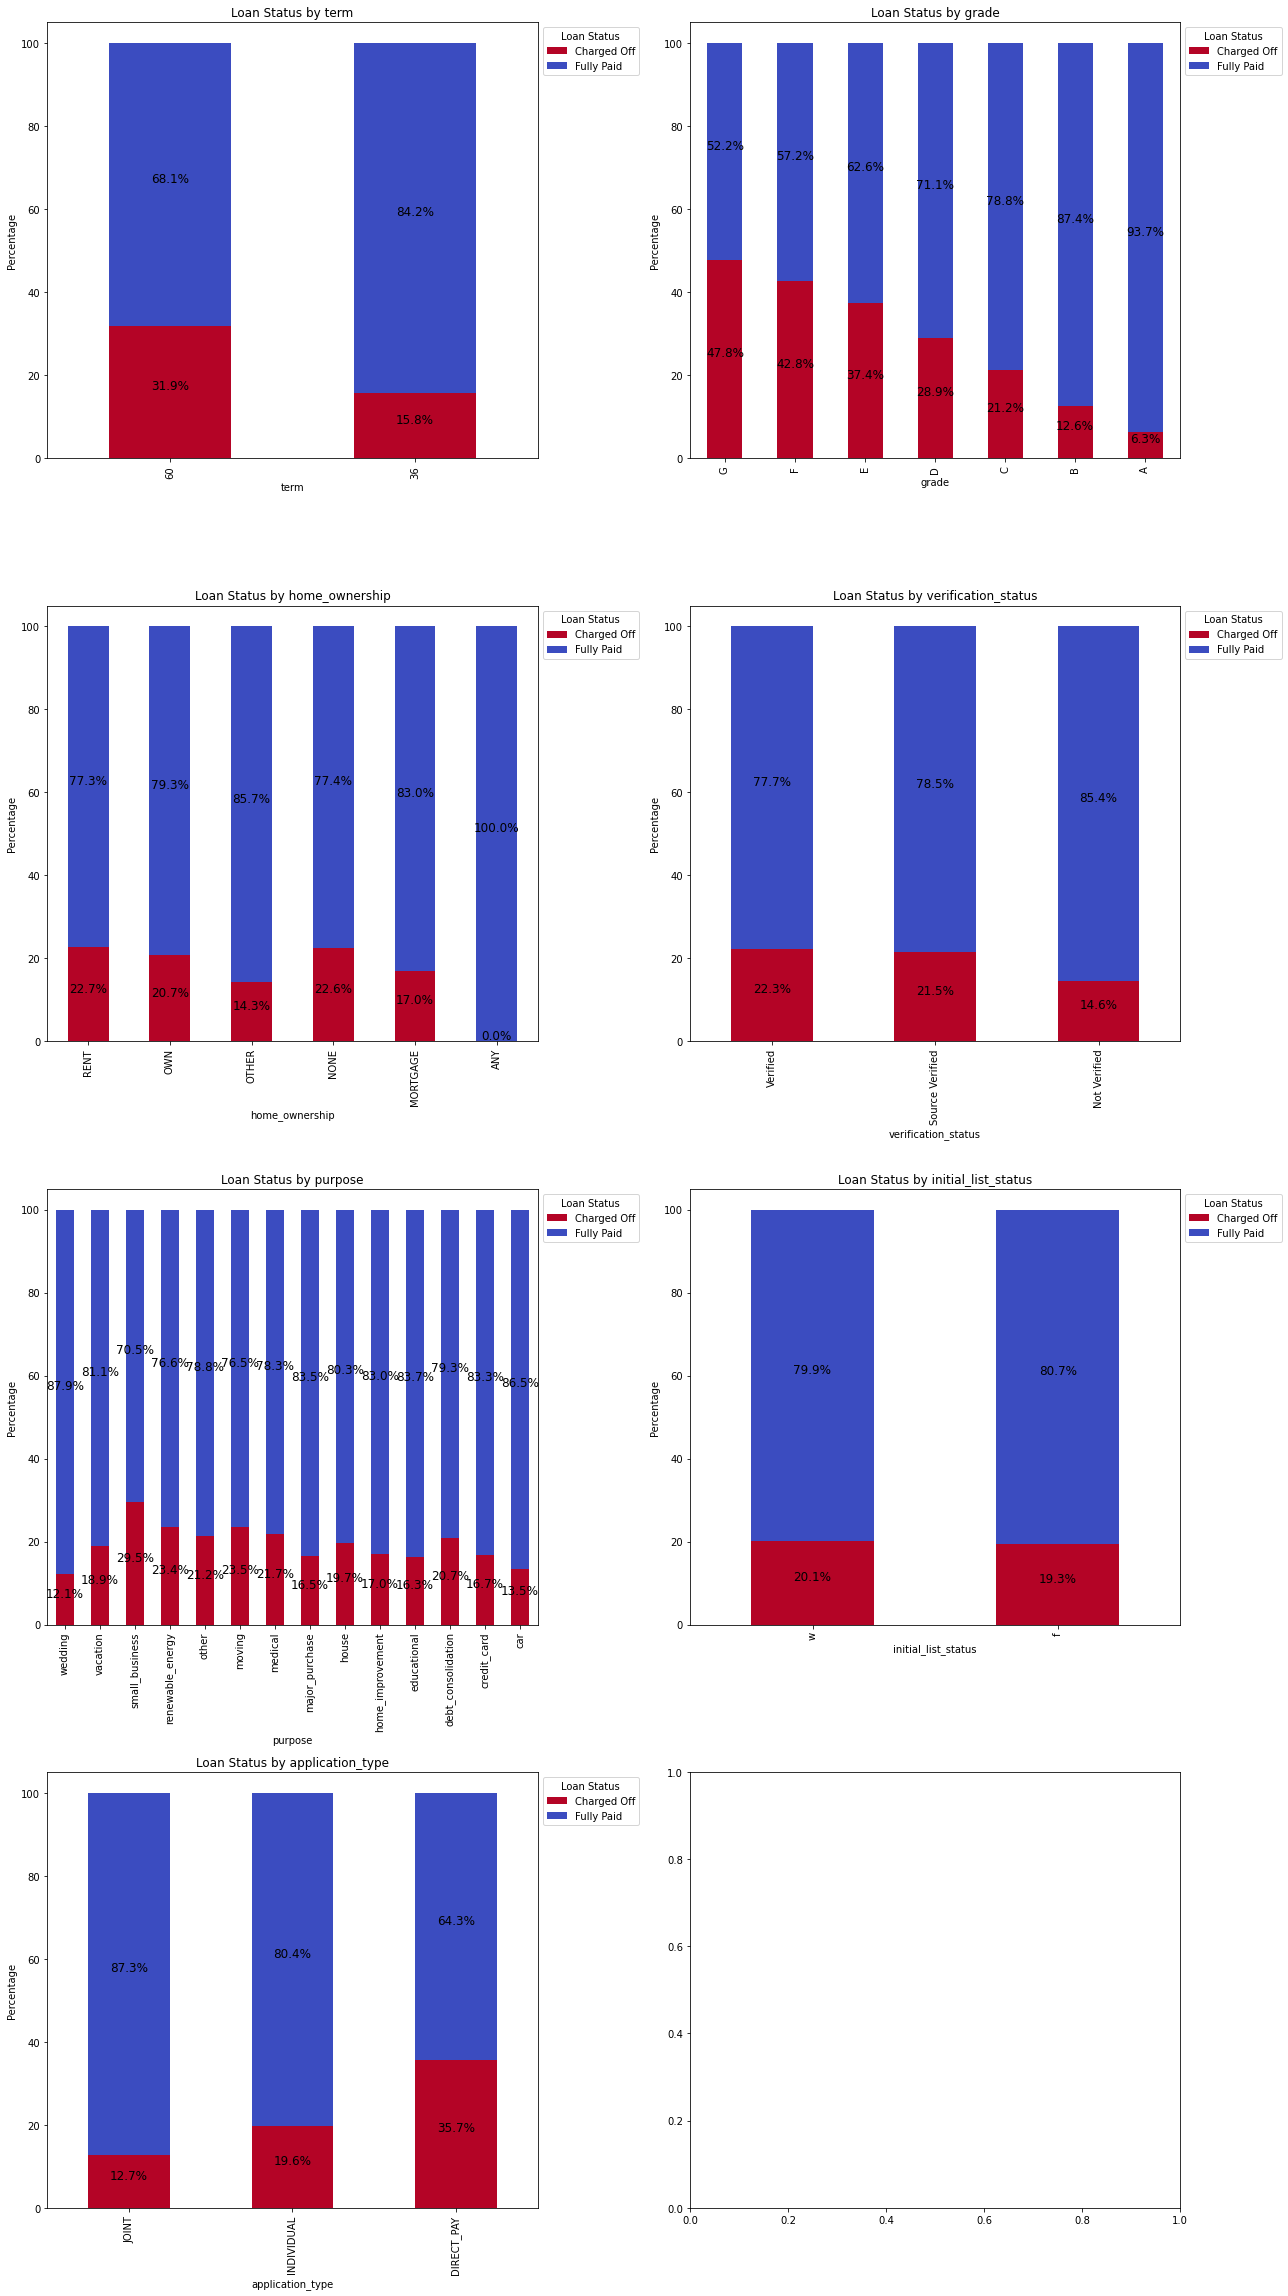

In [27]:
columns_to_plot = ['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']

# Calculate the number of rows and columns for the grid layout
num_cols = 2
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 8 * num_rows))
fig.subplots_adjust(hspace=0.5)

# Loop through columns and create distribution plots
for i, column in enumerate(columns_to_plot):
    grouped = df.groupby([column, 'loan_status']).size().unstack()

    # Calculate percentages
    grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Create an upside-down stacked bar chart with percentages
    ax = axes[i // num_cols, i % num_cols]
    grouped_percentage.plot(kind='bar', stacked=True, colormap='coolwarm_r', ax=ax)
    ax.invert_xaxis()  # Invert the x-axis to make it upside-down

    # Add percentage labels inside bars
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fontsize=12, padding=6, labels=[f'{val:.1f}%' for val in container.datavalues])

    ax.set_title(f'Loan Status by {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Percentage')

    # Move legend outside the graph
    ax.legend(title='Loan Status', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### Insight 
few feature like grade, home_ownership, purpose, application_type have few categories which have some categories which are significantly less in number with comparision to other category present in same feature but if analyse those categories by looking at our Bivariate analysis charts we can see although those categories are less in numbers but the distribution of loan_status within that categories is significant .

#### Action 
We can't ignore any categorical column mentioned above 

#### Extracting zip_code and state_code from 'address' Feature

In [28]:
df['zip_code'] = df['address'].str.split(',').str[1].str.split().str[-1]

In [29]:
df['state_code'] = df['address'].str.split(',').str[1].str.split().str[-2]

#### Univariate and Bivariate analysis over zip_code column

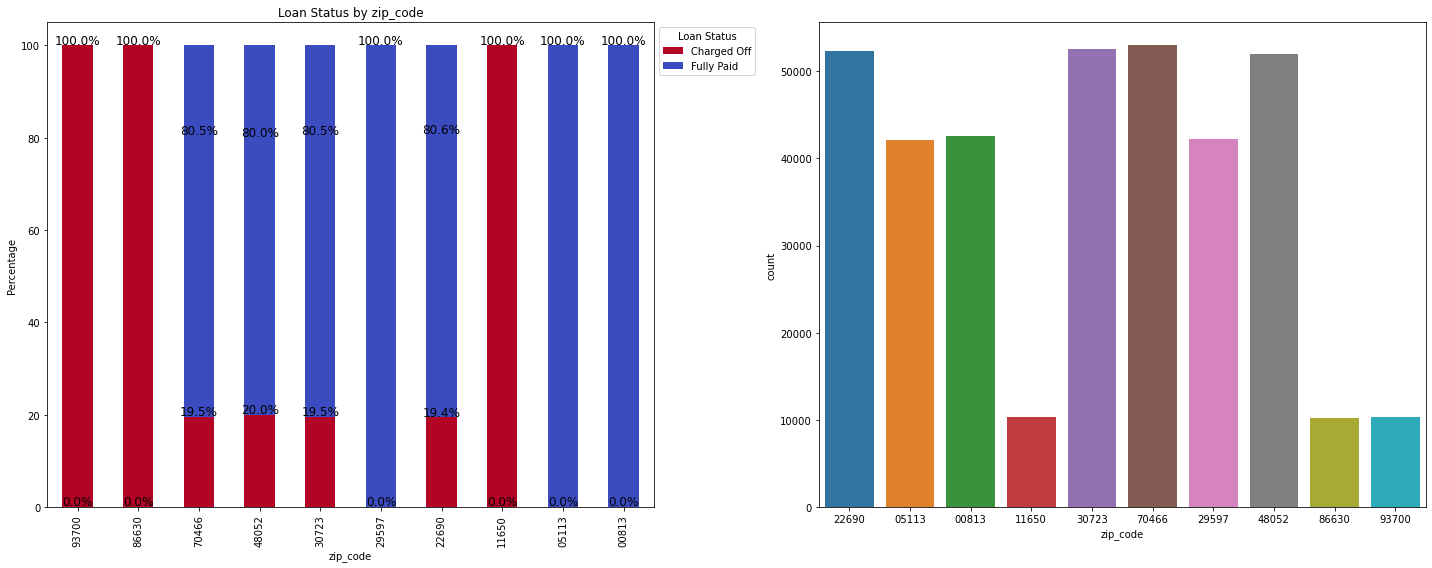

In [30]:
grouped = df.groupby(['zip_code', 'loan_status']).size().unstack()
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Subplot 1: Stacked bar chart with percentages
ax1 = axes[0]
grouped_percentage.plot(kind='bar', stacked=True, colormap='coolwarm_r', ax=ax1)
ax1.invert_xaxis()  # Invert the x-axis to make it consistent with your original request

# Add percentage labels inside bars
for container in ax1.containers:
    for patch in container.patches:
        ax1.annotate(f'{patch.get_height():.1f}%', (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                     ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

ax1.set_title('Loan Status by zip_code')
ax1.set_xlabel('zip_code')
ax1.set_ylabel('Percentage')
ax1.legend(title='Loan Status', bbox_to_anchor=(1, 1), loc='upper left')

# Subplot 2: Count plot of unique zip codes
ax2 = axes[1]
sns.countplot(data=df, x='zip_code', ax=ax2)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [31]:
df.describe(include = 'object')

,grade,sub_grade,emp_title,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address,zip_code,state_code
count,396030,396030,396030,396030,396030,396030,396030,396030,396030,396030,396030,396030,396030,367706,367706
unique,7,35,173105,6,3,115,2,14,48817,684,2,3,393700,10,54
top,B,B3,Other,MORTGAGE,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,Oct-2000,f,INDIVIDUAL,USCGC Smith\r\nFPO AE 70466,70466,NJ
freq,116018,26655,22928,198348,139563,14846,318357,234507,154227,3017,238066,395319,8,52970,7091


#### Insight 
Following columns has too many categories within them so applying one hot encoding will generate so many dimmensions in our dataset that handling them will become a hectic job 
e.g "sub_grade", "emp_title", "issue_d", "purpose", "title", "earliest_cr_line", "address", "state_code"

#### Action 
we will drop these columns 

In [32]:
df.drop(columns = ["sub_grade", "emp_title", "issue_d", "title", "earliest_cr_line", "address", "state_code"]
        , axis = 1, inplace = True)
df.sample(5)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
312633,21375.0,60,23.28,606.02,F,6.0,MORTGAGE,72000.0,Verified,Charged Off,...,14.0,0.0,15124.0,67.2,31.0,f,INDIVIDUAL,2.0,0.0,NaN
38727,12000.0,60,12.69,271.14,C,0.5,MORTGAGE,75000.0,Not Verified,Fully Paid,...,14.0,0.0,10194.0,75.5,36.0,w,INDIVIDUAL,2.0,0.0,48052
219897,10800.0,60,22.15,299.21,E,9.0,RENT,36213.0,Source Verified,Charged Off,...,9.0,1.0,3352.0,48.6,16.0,w,INDIVIDUAL,1.0,1.0,86630
283959,7500.0,36,11.59,247.65,C,2.0,RENT,116600.0,Not Verified,Fully Paid,...,19.0,0.0,25588.0,58.0,33.0,f,INDIVIDUAL,0.0,0.0,48052
325141,12800.0,60,14.99,304.45,C,2.0,RENT,44915.0,Source Verified,Charged Off,...,19.0,0.0,7776.0,62.2,32.0,w,INDIVIDUAL,0.0,0.0,70466


In [33]:
df['zip_code'] = df['zip_code'].fillna(df['zip_code'].mode()[0])

In [34]:
df['zip_code'].isnull().sum()

0

#### Checking for outliers 

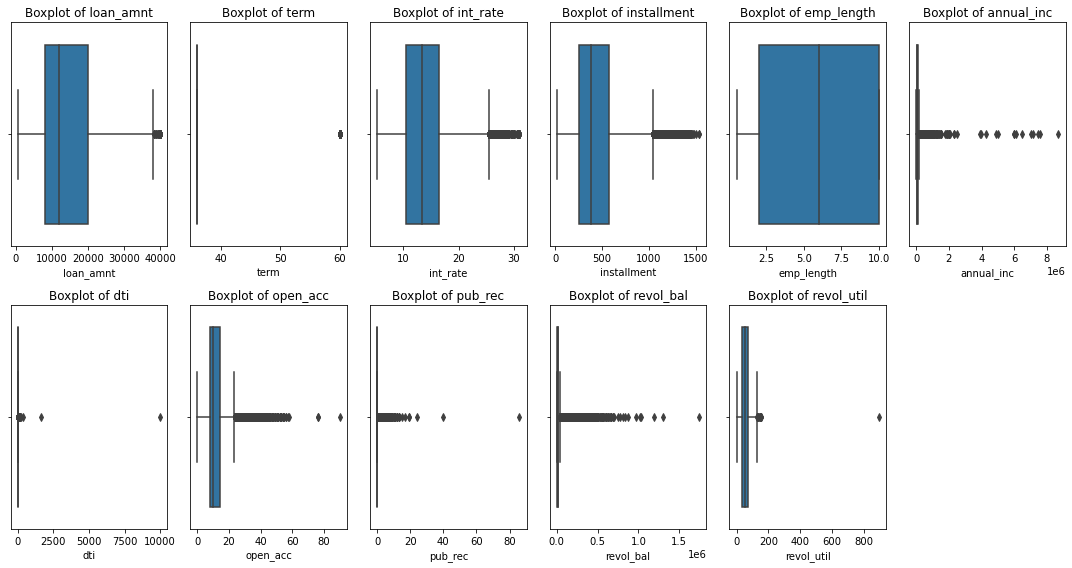

In [35]:
numerical_data = df.select_dtypes(include='number')
num_cols = numerical_data.columns

def box_plot(col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Create a 2x6 grid for the first 11 numerical columns
plt.figure(figsize=(15, 8))  # Adjust the figure size

for idx, col in enumerate(num_cols[:11], 1):
    plt.subplot(2, 6, idx)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

#### Removing outliers and checking shape of updated dataframe

In [36]:
numerical_data = df.select_dtypes(include='number')
num_cols = numerical_data.columns

def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_limit) & (data[col] <= upper_limit)]

# Iterate through numerical columns and remove outliers
for col in num_cols:
    df = remove_outliers(df, col)

# Display the shape of the DataFrame after removing outliers
df.shape

(202816, 22)

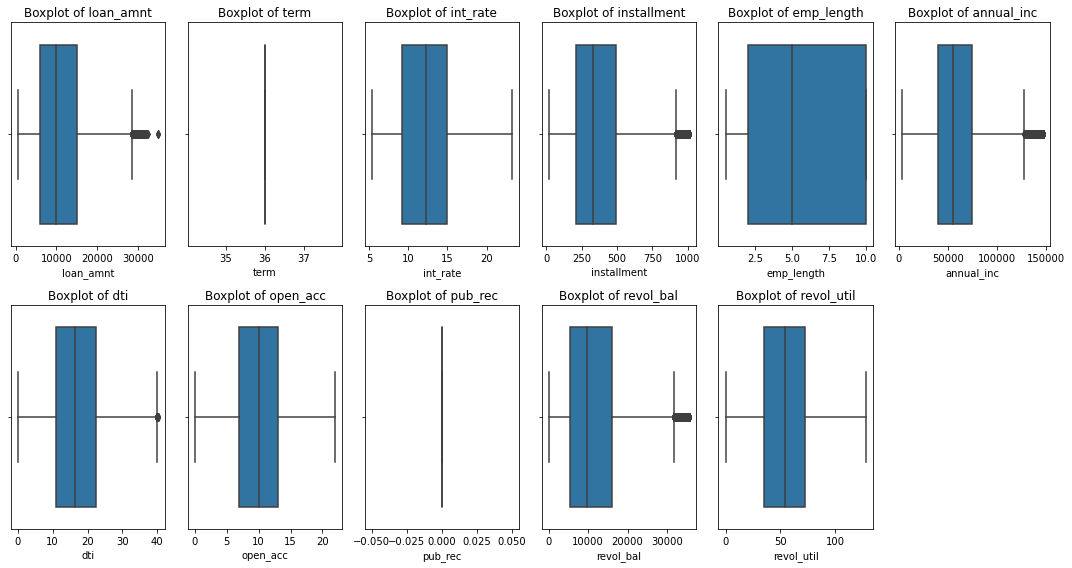

In [37]:
numerical_data = df.select_dtypes(include='number')
num_cols = numerical_data.columns

def box_plot(col):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Create a 2x6 grid for the first 11 numerical columns
plt.figure(figsize=(15, 8))  # Adjust the figure size

for idx, col in enumerate(num_cols[:11], 1):
    plt.subplot(2, 6, idx)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

#### maping binary features with 0 and 1 

In [38]:
list_status = {'w': 0, 'f': 1}
df['initial_list_status'] = df.initial_list_status.map(list_status)

#### Performing OneHotEncoding on feature having multiple variable 

In [39]:
dummies=['purpose', 'zip_code', 'grade', 'verification_status', 'application_type', 'home_ownership']
df = pd.get_dummies(df, columns=dummies, drop_first=True)

df.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,...,grade_G,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
1,8000.0,36,11.99,265.68,4.0,65000.0,Fully Paid,22.05,17.0,0.0,...,0,0,0,1,0,1,0,0,0,0
2,15600.0,36,10.49,506.97,0.5,43057.0,Fully Paid,12.79,13.0,0.0,...,0,1,0,1,0,0,0,0,0,1
3,7200.0,36,6.49,220.65,6.0,54000.0,Fully Paid,2.60,6.0,0.0,...,0,0,0,1,0,0,0,0,0,1
5,20000.0,36,13.33,677.07,10.0,86788.0,Fully Paid,16.31,8.0,0.0,...,0,0,1,1,0,1,0,0,0,0
6,18000.0,36,5.32,542.07,2.0,125000.0,Fully Paid,1.36,8.0,0.0,...,0,1,0,1,0,1,0,0,0,0


In [40]:
list_status = {'Fully Paid': 0, 'Charged Off': 1}
df['loan_status'] = df.loan_status.map(list_status)

In [41]:
df.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,...,grade_G,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
12702,6000.0,36,12.49,200.70,0.5,27000.0,1,16.98,7.0,0.0,...,0,0,1,1,0,1,0,0,0,0
38112,12000.0,36,13.99,410.08,4.0,104000.0,0,18.06,19.0,0.0,...,0,0,0,1,0,1,0,0,0,0
3476,11325.0,36,17.77,408.13,10.0,52000.0,0,26.08,19.0,0.0,...,0,0,1,1,0,1,0,0,0,0
215786,8325.0,36,19.05,305.38,0.5,25000.0,0,15.65,8.0,0.0,...,0,0,1,1,0,0,0,0,0,1
33437,9600.0,36,9.67,308.28,10.0,50000.0,0,15.91,5.0,0.0,...,0,1,0,1,0,1,0,0,0,0


#### Defining dependent and independent features 

In [42]:
X=df.drop('loan_status',axis=1)
y=df['loan_status']

#### Performing train test split on our X and y

In [43]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.20,stratify=y,random_state=42)

In [44]:
y_train.value_counts()

0    136695
1     25557
Name: loan_status, dtype: int64

#### Scaling numerical columns present in our train and test dataset

In [45]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Building Logistic regression model 

In [46]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

#### Checking accuracy of model on train and test dataset

In [47]:
y_pred = logreg.predict(X_train)
print('Accuracy of Logistic Regression Classifier on train set: {:.3f}'.format(logreg.score(X_train, y_train)))

Accuracy of Logistic Regression Classifier on train set: 0.906


In [48]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.905


In [49]:
X_train = pd.DataFrame(X_train, columns=X.columns)

#### Evaluating features and removing feature with VIF value greater than 5 we will repeat this untill we get only those features having VIF values less than 5 

In [50]:
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

calc_vif(X_train)[:5]

,Feature,VIF
45,application_type_INDIVIDUAL,10145.94
51,home_ownership_RENT,4932.39
47,home_ownership_MORTGAGE,4309.95
50,home_ownership_OWN,1006.37
0,loan_amnt,765.74


In [51]:
X_train.drop(columns=['home_ownership_RENT'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
0,loan_amnt,765.36
3,installment,758.50
45,application_type_INDIVIDUAL,103.96
2,int_rate,48.71
16,purpose_debt_consolidation,41.89


In [52]:
X_train.drop(columns=['installment'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
44,application_type_INDIVIDUAL,98.04
15,purpose_debt_consolidation,41.86
2,int_rate,40.49
14,purpose_credit_card,16.77
6,open_acc,14.37


In [53]:
X_train.drop(columns=['application_type_INDIVIDUAL'],axis=1,inplace=True)  
calc_vif(X_train)[:5]

,Feature,VIF
2,int_rate,39.95
15,purpose_debt_consolidation,15.78
6,open_acc,14.14
10,total_acc,10.74
38,grade_D,9.90


In [54]:
X_train.drop(columns=['int_rate'],axis=1,inplace=True) 
calc_vif(X_train)[:5]

,Feature,VIF
14,purpose_debt_consolidation,15.34
5,open_acc,14.04
9,total_acc,10.73
8,revol_util,9.28
3,annual_inc,8.39


In [55]:
X_train.drop(columns=['purpose_debt_consolidation'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
5,open_acc,13.36
9,total_acc,10.72
8,revol_util,8.58
3,annual_inc,7.91
4,dti,7.28


In [56]:
X_train.drop(columns=['open_acc'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
7,revol_util,8.17
3,annual_inc,7.74
8,total_acc,7.09
4,dti,6.74
0,loan_amnt,5.51


In [57]:
X_train.drop(columns=['revol_util'],axis=1,inplace=True)  
calc_vif(X_train)[:5]

,Feature,VIF
3,annual_inc,7.56
7,total_acc,6.89
4,dti,6.52
0,loan_amnt,5.49
6,revol_bal,4.56


In [58]:
X_train.drop(columns=['annual_inc'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
6,total_acc,6.30
3,dti,6.19
0,loan_amnt,4.82
5,revol_bal,4.39
2,emp_length,2.90


In [59]:
X_train.drop(columns=['total_acc'],axis=1,inplace=True)
calc_vif(X_train)[:5] 

,Feature,VIF
3,dti,5.50
0,loan_amnt,4.71
5,revol_bal,4.33
2,emp_length,2.87
6,initial_list_status,2.70


In [60]:
X_train.drop(columns=['dti'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
0,loan_amnt,4.71
4,revol_bal,4.01
2,emp_length,2.84
5,initial_list_status,2.70
38,home_ownership_MORTGAGE,2.69


In [61]:
X_test = pd.DataFrame(X_test, columns=X.columns)

In [62]:
X_test.drop(columns =  ['home_ownership_RENT','revol_util','dti','total_acc','purpose_debt_consolidation','installment','annual_inc','application_type_INDIVIDUAL','int_rate','open_acc'],axis = 1 ,inplace = True)

#### Rebulding the logistic regression model afetr removing high VIF valued columns 

In [63]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [64]:
y_pred = logreg.predict(X_train)
print('Accuracy of Logistic Regression Classifier on train set: {:.3f}'.format(logreg.score(X_train, y_train)))

Accuracy of Logistic Regression Classifier on train set: 0.906


In [70]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on train set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on train set: 0.905


#### building confusion matrix

In [71]:
from sklearn.metrics import confusion_matrix

# Assuming you already have the confusion_matrix computed
confusion_matrix_values = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix into a dataframe
confusion_df = pd.DataFrame(confusion_matrix_values, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
confusion_df

,Predicted Negative,Predicted Positive
Actual Negative,34174,0
Actual Positive,3856,2534


Q6. which metric should our primary focus be on..
ROC AUC
Precision
Recall
F1 Score

#### Ans6 - RECALL since in our case False negetive is a dangerous mistake because machine will prodict that loan will be fully paid but in actual it will not 

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     34174
           1       1.00      0.40      0.57      6390

    accuracy                           0.90     40564
   macro avg       0.95      0.70      0.76     40564
weighted avg       0.91      0.90      0.89     40564



#### Insight 
in our model recall is coming very low while it is the most important matrix for or model 

#### Action 
we will try to increase recall value by changing thrushold values

#### Building a new model with a diffrent threshold value for better recall value for 1 

In [77]:
from sklearn.linear_model import LogisticRegression

# Create the model with adjusted class weights
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [99]:
# After training the model
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.25) 

In [100]:
from sklearn.metrics import confusion_matrix

# Assuming you already have the confusion_matrix computed
confusion_matrix_values = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix into a dataframe
confusion_df = pd.DataFrame(confusion_matrix_values, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
confusion_df

,Predicted Negative,Predicted Positive
Actual Negative,15671,18503
Actual Positive,115,6275


In [101]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.46      0.63     34174
           1       0.25      0.98      0.40      6390

    accuracy                           0.54     40564
   macro avg       0.62      0.72      0.51     40564
weighted avg       0.88      0.54      0.59     40564



#### Our recall value has increased and has become 0.98 now 

### ROC curve

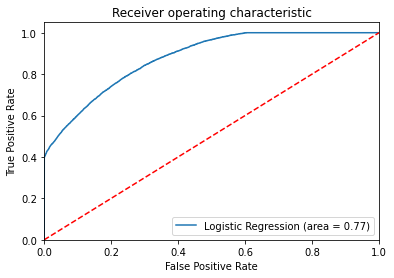

In [102]:
logit_roc_auc=roc_auc_score(y_test,logreg.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

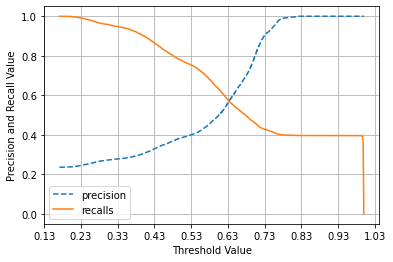

In [103]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, logreg.predict_proba(X_test)[:,1])

Q7. How does the gap in precision and recall affect the bank?

#### Ans7 - model can make two kind of mistakes one is false positive and other is false negetive so to understand these mistakes we need to calculate recall and precision so if recall is less it will be dangerous for bank 

Q8. Which were the features that heavily affected the outcome?

#### Ans8 - address seems to be most important feature in our case

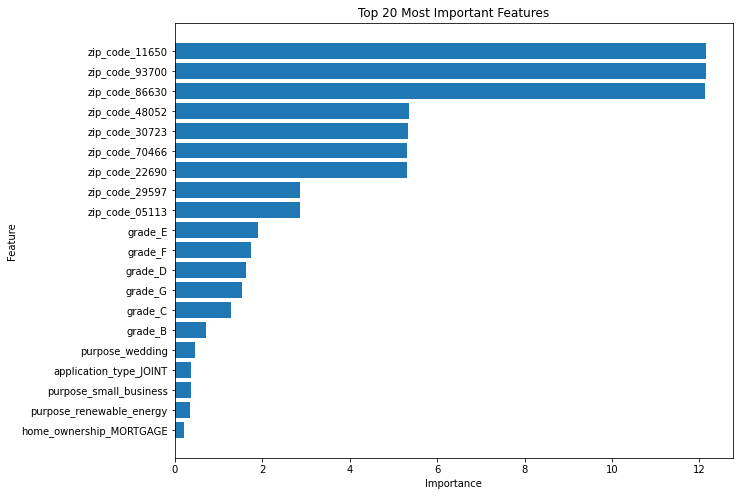

In [104]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the model
logreg.fit(X_train, y_train)

# Retrieve feature coefficients
feature_importance = logreg.coef_[0]

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by absolute importance values
feature_importance_df['Importance'] = abs(feature_importance_df['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top N most important features
top_n = 20  # Set the number of top features you want to display
top_features = feature_importance_df.head(top_n)

# Plot the top features
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()  # Invert y

Q9. Will the results be affected by geographical location?
#### Ans9 - Yes, from above graph we can see that zip_code is a very important feature so geographical location has impact on our result 